In [1]:
%matplotlib inline

import pandas as pd
import requests
import xml.etree.cElementTree as et

In [2]:
# Парсим  xml в два листа, из которых сделаем DataFrame.

# Ссылка на прямой эфир.
url = 'http://export.yandex.ru/last/last20x.xml'
# Два пустых листа, в которые запишем запросы из прямого эфира.
ls_found = []
ls_item = []
# За однин request Яндекс дает нам 1000 запросов. Сделаем 10 запросов, чтобы получить 10 000.
for i in range(10):
    # Библиотекой requests возьмем xml файл по ссылке.
    xml_doc = requests.get(url).text
    # Парсим xml в 2 листа.
    tree = et.fromstring(xml_doc)
    # 2 листа, т.к. вдург "found" пригодится в качетве id.
    ls_found.extend([x.attrib['found'] for x in tree.findall('./last20x/')])
    ls_item.extend([x.text for x in tree.findall('./last20x/')])

In [3]:
# Сделаем DataFrame.
df = pd.DataFrame({'found': ls_found, 'item': ls_item})

In [4]:
df.head()

,found,item
0,447966,slots free games cleopatra
1,595592,бьет бит iowa слушать
2,4652316,как сделать природу чище
3,2767765,вход в модем
4,4399859,3d в телевизоре нужен или нет


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import re

from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.stem.snowball import SnowballStemmer

import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.cluster.hierarchy import ward, dendrogram

In [6]:
# Делаем список стоп-слов.
stopwords = nltk.corpus.stopwords.words('russian')

In [7]:
# Стеммер.
stemmer = SnowballStemmer('russian')

In [8]:
def tokenizing_stemming(text):
    # Токенизация.
    tokens = [word.lower() for word in nltk.word_tokenize(text)]
    filtered_tokens = []
    # Возьмем слова содержащие только буквы.
    for token in tokens:
        if re.search('[а-яА-Яa-zA-Z]', token):
            filtered_tokens.append(token.lower())
    # Стемминг.
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [9]:
# Кодируем в TF-IDF.
transformer = TfidfVectorizer(max_df = 0.9, min_df = 0.01, stop_words=stopwords, ngram_range=(1,3),
                              use_idf=True,
                              tokenizer=tokenizing_stemming)
tfidf_requests = transformer.fit_transform(df['item'])

In [10]:
# Расстояния для кластеризации.
distance = 1 - cosine_similarity(tfidf_requests)

In [11]:
# Кластеризация K-means.
from sklearn.cluster import KMeans

numb_clusters = 5

km = KMeans(n_clusters=numb_clusters)

km.fit(tfidf_requests)

clusters = km.labels_.tolist()

In [12]:
from collections import Counter
Counter(clusters)

Counter({0: 369, 1: 8903, 2: 233, 3: 245, 4: 250})

In [32]:
# Ближайшие 3 стема к центру каждого кластера.
print('Ближайшие 3 стема к центру каждого кластера:')
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = transformer.get_feature_names()
cluster_names = {}
for i in range(numb_clusters):
    print("Кластер %d:" % i),
    tops = []
    for ind in order_centroids[i, :3]:
        print(' %s' % terms[ind])
        tops.append(terms[ind])
    cluster_names[i] = ', '.join(tops)
    
# Этот словарь будем использовать для легенды на графике.
print(cluster_names)

Ближайшие 3 стема к центру каждого кластера:
Кластер 0:
 смотрет
 онлайн
 смотрет онлайн
Кластер 1:
 цен
 фот
 класс
Кластер 2:
 сайт
 официальн
 официальн сайт
Кластер 3:
 куп
 москв
 магазин
Кластер 4:
 скача
 бесплатн
 игр
{0: 'смотрет, онлайн, смотрет онлайн', 1: 'цен, фот, класс', 2: 'сайт, официальн, официальн сайт', 3: 'куп, москв, магазин', 4: 'скача, бесплатн, игр'}


In [28]:
import os

import matplotlib.pyplot as plt
import matplotlib as mpl

In [29]:
# Присваиваем кластерам цвета.
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

In [30]:
from sklearn.decomposition import PCA

# Понижаем размерность до 2х, чтобы отобразить запросы на плоскости.
pca = PCA(svd_solver='randomized', n_components=2, random_state=1)

pos = pca.fit_transform(distance)

xs, ys = pos[:, 0], pos[:, 1]

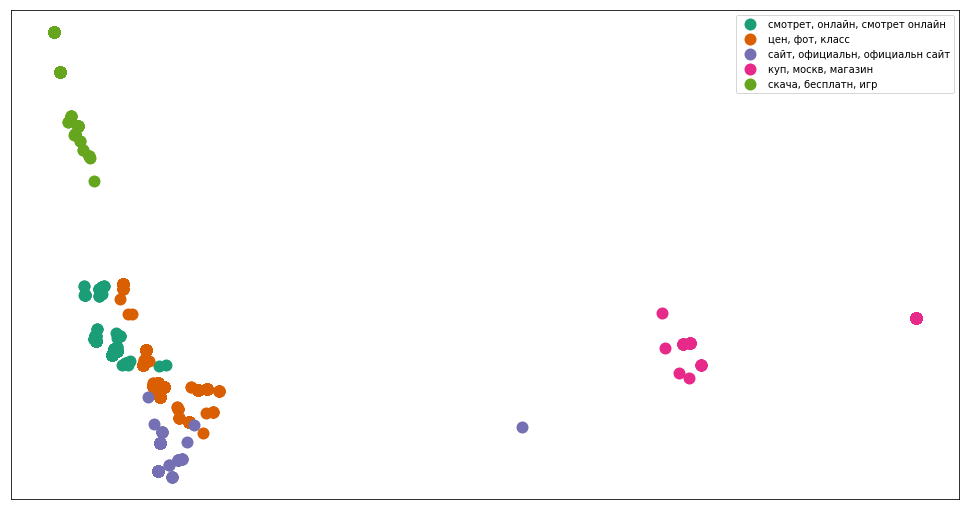

In [31]:
# Нарисуем запросы.

# Этот DataFrame будем рисовать. Тут результаты PCA и названия кластеров.
df_pca = pd.DataFrame(dict(x=xs, y=ys, label=clusters)) 

# Сгруппируем по кластерам.
groups = df_pca.groupby('label')

# Рисуем.
fig, ax = plt.subplots(figsize=(17, 9)) 
ax.margins(0.05) 

for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         
        which='both',      
        bottom='off',      
        top='off',         
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         
        which='both',      
        left='off',      
        top='off',         
        labelleft='off')
    
ax.legend(numpoints=1)  
    
plt.savefig('clusters.png', dpi=200)    
plt.show() 

# Отчет 

### Задача: 
Кластеризовать 10 000 поисковых запросов из прямого эфира Яндекса.

Для кластеризации запросы были размечени, используя метод TF-IDF. Слова были разделены на стемы, используя стеммер библиотеки NLTK.

В качестве алгоритма был выбран K-means. Кажется, что можно будет интерпретировать координаты центров кластеров (стемы). Решено было попробовать разбить запросы на 5 кластеров.

Получилось следующее разбиение (номер_кластера: количество_элементов): 0: 369, 1: 8903, 2: 233, 3: 245, 4: 250.
Посмотрим на координаты центров кластеров, а точнее ближайшие к ним 3 стема:

Номер кластера | Ближайшие стемы | К-во элементов
:---: | :---: | :---:
0: | 'смотрет, онлайн, смотрет онлайн',  |  369
1: | 'цен, фот, класс',                  |  8903
2: | 'сайт, официальн, официальн сайт',  |  233
3: | 'куп, москв, магазин',              |  245
4: | 'скача, бесплатн, игр',             |  250

Получившиеся результаты можно интерпретировать так: подавляющее большинство людей ищут цены на товары и фото (возможно, товаров) - 1 кластер, затем идет группа тех, кто хочет посмотреть кино онлайн - 0 кластер, остальные 3 группы равночисленны и в этих запросах люди ищут официальные сайты - 2 кластер, хотят купить в магазина в мосве что-то - 3 кластер, хотят бесплатно скачать игры - 4 кластер.

Изобразим на плоскости наши данные и покрасить точки относящиеся к одному кластеру в одинаковые цвета. Понизим размерность данных используя метод главных компонент.
Ближайшие к центрам кластера стемы указаны на легенде графика.
<img src="clusters.png">

Интересно, можно заметить, что дальше всех разнесены кластеры 'куп, москв, магазин', 'скача, бесплатн, игр', что имеет смысл.